importing data from:
https://drive.google.com/drive/u/5/folders/1Reinrqy8hasHlz-NAwEwcxqMAIJ3084q (CIFAKE https://www.kaggle.com/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images)

In [1]:
!pip install -U --no-cache-dir gdown --pre
!pip install tensorflow_model_optimization
!pipc install tensorflow.keras
#!gdown --id '1keraXkkR9hY-RLcpAJGci03qvgdMYkBl' --output Dataset.zip
!gdown --id '1gNW1B1czIrASEFK79864oMVVtbXNuZs4' --output Dataset.zip

!unzip Dataset.zip

串流輸出內容已截斷至最後 5000 行。
  inflating: train/REAL/4500 (10).jpg  
  inflating: train/REAL/4500 (2).jpg  
  inflating: train/REAL/4500 (3).jpg  
  inflating: train/REAL/4500 (4).jpg  
  inflating: train/REAL/4500 (5).jpg  
  inflating: train/REAL/4500 (6).jpg  
  inflating: train/REAL/4500 (7).jpg  
  inflating: train/REAL/4500 (8).jpg  
  inflating: train/REAL/4500 (9).jpg  
  inflating: train/REAL/4500.jpg     
  inflating: train/REAL/4501 (10).jpg  
  inflating: train/REAL/4501 (2).jpg  
  inflating: train/REAL/4501 (3).jpg  
  inflating: train/REAL/4501 (4).jpg  
  inflating: train/REAL/4501 (5).jpg  
  inflating: train/REAL/4501 (6).jpg  
  inflating: train/REAL/4501 (7).jpg  
  inflating: train/REAL/4501 (8).jpg  
  inflating: train/REAL/4501 (9).jpg  
  inflating: train/REAL/4501.jpg     
  inflating: train/REAL/4502 (10).jpg  
  inflating: train/REAL/4502 (2).jpg  
  inflating: train/REAL/4502 (3).jpg  
  inflating: train/REAL/4502 (4).jpg  
  inflating: train/REAL/4502 (5).jpg  
  i

In [2]:
import os
MODELS_DIR = 'models/'
if not os.path.exists(MODELS_DIR):
    os.mkdir(MODELS_DIR)
MODEL_TF = MODELS_DIR + 'model'
MODEL_NO_QUANT_TFLITE = MODELS_DIR + 'model_no_quant.tflite'
MODEL_TFLITE = MODELS_DIR + 'model.tflite'
MODEL_TFLITE_MICRO = MODELS_DIR + 'model.cc'

sample code from:
https://www.kaggle.com/code/birdy654/training-a-small-cnn-on-cifake

Reading data

In [3]:
import numpy as np
from tensorflow import keras

image_size = (32, 32)

# load dataset
train_dataset = keras.utils.image_dataset_from_directory(
    "/content/train",
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=image_size,
    label_mode="binary",
)

val_dataset = keras.utils.image_dataset_from_directory(
    "/content/train",
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=image_size,
    label_mode="binary",
)


test_dataset = keras.utils.image_dataset_from_directory(
    "/content/test",
    image_size=image_size,
    label_mode="binary",
)

Found 100000 files belonging to 2 classes.
Using 80000 files for training.
Found 100000 files belonging to 2 classes.
Using 20000 files for validation.
Found 20000 files belonging to 2 classes.


In [4]:
import tensorflow as tf

# offload most images to disk
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

Building Model

In [6]:
from tensorflow.keras.layers import Dense
# Building the CNN
layers = []
layers.append(tf.keras.layers.Rescaling(1./255)) # Normalise pixel values
layers.append(tf.keras.layers.Conv2D(32, 3, activation='relu'))
layers.append(tf.keras.layers.MaxPooling2D())

layers.append(tf.keras.layers.Conv2D(32, 3, activation='relu'))
layers.append(tf.keras.layers.MaxPooling2D())

layers.append(tf.keras.layers.Conv2D(32, 3, activation='relu'))
layers.append(tf.keras.layers.MaxPooling2D())

layers.append(tf.keras.layers.Flatten())

# Building the ANN
layers.append(tf.keras.layers.Dense(32, activation='relu'))
layers.append(tf.keras.layers.Dense(1, activation='sigmoid'))

# Create and compile the model from layers
model = tf.keras.Sequential(layers)
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.BinaryCrossentropy(),
  metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

# Build the model so we can see a summary
model.build(input_shape=(None, 32, 32, 3))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 32, 32, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 32)          9

Training Model

In [7]:
from keras.callbacks import EarlyStopping, ModelCheckpoint


callbacks = [EarlyStopping(monitor='val_loss', patience=10), ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]
history = model.fit(train_dataset, validation_data=val_dataset, epochs=5, callbacks=callbacks, shuffle=True)


Epoch 1/5
2500/2500 [==============================] - 31s 9ms/step - loss: 0.3709 - accuracy: 0.8328 - precision: 0.8269 - recall: 0.8420 - val_loss: 0.2761 - val_accuracy: 0.8849 - val_precision: 0.8660 - val_recall: 0.9105


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/5
2500/2500 [==============================] - 14s 6ms/step - loss: 0.2661 - accuracy: 0.8899 - precision: 0.8911 - recall: 0.8884 - val_loss: 0.2448 - val_accuracy: 0.9033 - val_precision: 0.9358 - val_recall: 0.8659
Epoch 3/5
2500/2500 [==============================] - 14s 6ms/step - loss: 0.2270 - accuracy: 0.9088 - precision: 0.9099 - recall: 0.9074 - val_loss: 0.2146 - val_accuracy: 0.9132 - val_precision: 0.9109 - val_recall: 0.9158
Epoch 4/5
2500/2500 [==============================] - 16s 6ms/step - loss: 0.2080 - accuracy: 0.9157 - precision: 0.9161 - recall: 0.9151 - val_loss: 0.2377 - val_accuracy: 0.9047 - val_precision: 0.8693 - val_recall: 0.9527
Epoch 5/5
2500/2500 [==============================] - 15s 6ms/step - loss: 0.1929 - accuracy: 0.9226 - precision: 0.9234 - recall: 0.9217 - val_loss: 0.2053 - val_accuracy: 0.9196 - val_precision: 0.9379 - val_recall: 0.8985


In [8]:
from keras.models import load_model
from tensorflow.keras import models
import matplotlib.pyplot as plt
import tempfile
_, pretrained_weights = tempfile.mkstemp('.tf')

model.save_weights(pretrained_weights)
model = load_model('./best_model.h5')

metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

Parameters Visualization

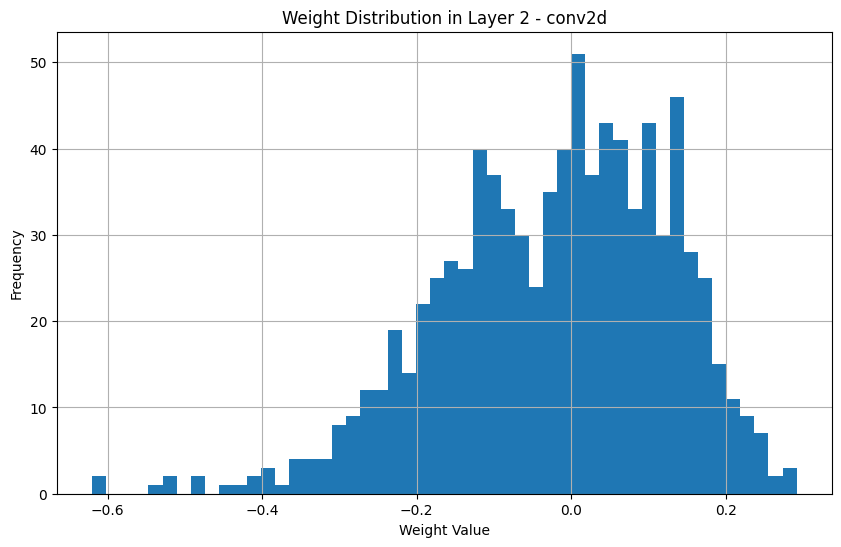

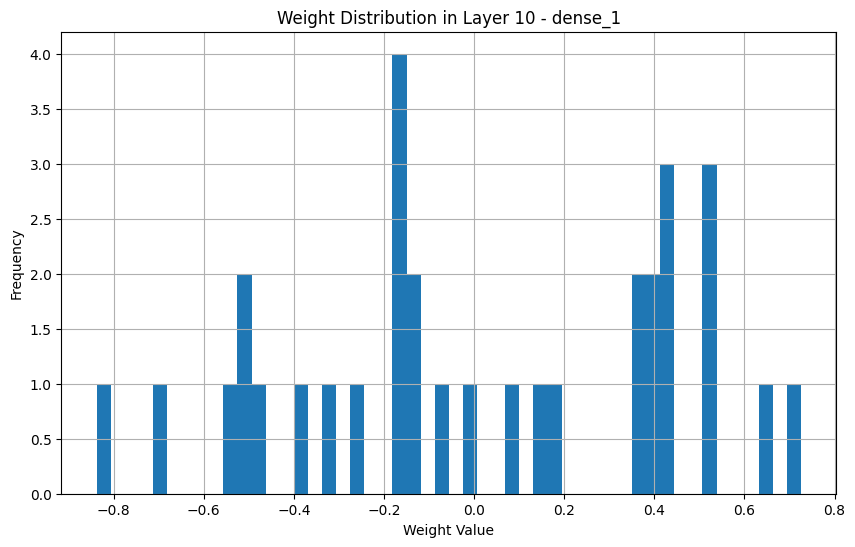

In [9]:
model = load_model('./best_model.h5')

# Function to plot histogram of layer weights
def plot_weight_histogram(weights, layer_name):
    # Flatten the weight array to make it suitable for histogram
    weights_flattened = weights.flatten()
    plt.figure(figsize=(10, 6))
    plt.hist(weights_flattened, bins=50)
    plt.title(f'Weight Distribution in {layer_name}')
    plt.xlabel('Weight Value')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

# Iterate through each layer in the model and plot the weights
for i, layer in enumerate(model.layers):
    if layer.get_weights():  # Check if layer has weights
        weights = layer.get_weights()[0]  # Get the weights of the layer
        plot_weight_histogram(weights, layer_name=f'Layer {i+1} - {layer.name}')

Pruning (deprecated)

In [10]:
'''
import tempfile
import tensorflow_model_optimization as tfmot

model.load_weights(pretrained_weights) # optional but recommended for model accuracy




# Compute end step to finish pruning after 2 epochs.
batch_size = 128
epochs = 2
validation_split = 0.1 # 10% of training set will be used for validation set.

num_images = 80000 * (1 - validation_split)
end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                               final_sparsity=0.10,
                                                               begin_step=0,
                                                               end_step=end_step,
                                                               frequency=10)
}
def apply_pruning_to_Conv2D(layer):
  if isinstance(layer, tf.keras.layers.Conv2D):
    return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params)
  return layer
# Use `keras.models.clone_model` to apply `apply_pruning_to_dense`
# to the layers of the model.
model_for_pruning = keras.models.clone_model(
    model,
    clone_function=apply_pruning_to_Conv2D,
)

model_for_pruning.summary()
model_for_output = tfmot.sparsity.keras.strip_pruning(model_for_pruning)
model_for_output.summary()
log_dir = tempfile.mkdtemp()
callbacks = [
    tfmot.sparsity.keras.UpdatePruningStep(),
    # Log sparsity and other metrics in Tensorboard.
    tfmot.sparsity.keras.PruningSummaries(log_dir=log_dir)
]

model_for_pruning.compile(
      loss=keras.losses.categorical_crossentropy,
      optimizer='adam',
      metrics=['accuracy']
)

model_for_pruning.fit(
    train_dataset,
    callbacks=callbacks,
    epochs=2,
)
model_for_pruning.summary()
'''

"\nimport tempfile\nimport tensorflow_model_optimization as tfmot\n\nmodel.load_weights(pretrained_weights) # optional but recommended for model accuracy\n\n\n\n\n# Compute end step to finish pruning after 2 epochs.\nbatch_size = 128\nepochs = 2\nvalidation_split = 0.1 # 10% of training set will be used for validation set.\n\nnum_images = 80000 * (1 - validation_split)\nend_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs\npruning_params = {\n      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,\n                                                               final_sparsity=0.10,\n                                                               begin_step=0,\n                                                               end_step=end_step,\n                                                               frequency=10)\n}\ndef apply_pruning_to_Conv2D(layer):\n  if isinstance(layer, tf.keras.layers.Conv2D):\n    return tfmot.sparsity.keras.prun

Quantized Model

In [11]:
model=load_model('./best_model.h5')
model.save('/content')
converter = tf.lite.TFLiteConverter.from_saved_model('./')

def representative_dataset():
  for image_batch, labels_batch in train_dataset:
    yield [image_batch]

# Set the optimization flag.
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# Enforce integer only quantization
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
# Provide a representative dataset to ensure we quantize correctly.
converter.representative_dataset = representative_dataset
model_tflite = converter.convert()

# Save the model to disk
open(MODEL_TFLITE, "wb").write(model_tflite)

31136

In [12]:
interpreter = tf.lite.Interpreter(model_path='./models/model.tflite')
all_tensor_details = interpreter.get_tensor_details()
for tensor_item in all_tensor_details:
  print("Weight %s:" % tensor_item["name"])


Weight serving_default_rescaling_input:0:
Weight sequential/flatten/Const:
Weight sequential/dense_1/BiasAdd/ReadVariableOp:
Weight sequential/dense_1/MatMul:
Weight sequential/dense/BiasAdd/ReadVariableOp:
Weight sequential/dense/MatMul:
Weight sequential/conv2d_2/BiasAdd/ReadVariableOp:
Weight sequential/conv2d_2/Conv2D:
Weight sequential/conv2d_1/BiasAdd/ReadVariableOp:
Weight sequential/conv2d_1/Conv2D:
Weight sequential/conv2d/BiasAdd/ReadVariableOp:
Weight sequential/conv2d/Relu;sequential/conv2d/BiasAdd;sequential/conv2d_2/Conv2D;sequential/conv2d/Conv2D;sequential/conv2d/BiasAdd/ReadVariableOp:
Weight sequential/conv2d/Relu;sequential/conv2d/BiasAdd;sequential/conv2d_2/Conv2D;sequential/conv2d/Conv2D;sequential/conv2d/BiasAdd/ReadVariableOp1:
Weight sequential/max_pooling2d/MaxPool:
Weight sequential/conv2d_1/Relu;sequential/conv2d_1/BiasAdd;sequential/conv2d_2/Conv2D;sequential/conv2d_1/Conv2D;sequential/conv2d_1/BiasAdd/ReadVariableOp:
Weight sequential/max_pooling2d_1/MaxPoo

Model Output

In [16]:

# Convert to a C source file, i.e, a TensorFlow Lite for Microcontrollers model
!xxd -i {'./models/model.tflite'} > {'./models/model.cc'}

# Directory paths
real_dir = "/content/test/REAL"
fake_dir = "/content/test/FAKE"

# Get list of all image paths
real_images = [os.path.join(real_dir, img) for img in os.listdir(real_dir)]
fake_images = [os.path.join(fake_dir, img) for img in os.listdir(fake_dir)]

# Combine real and fake image paths
all_images = real_images + fake_images

# Initialize an empty list to store predictions
predictions = []

# Loop over all images
for img_path in all_images:
    # Load and preprocess the image
    img = keras.utils.img_to_array(keras.utils.load_img(img_path))
    img = np.array([img])  # Model expects a batch of images

    # Make prediction
    pred = model.predict(img)

    # Append prediction to the list
    predictions.append(pred)

# Print all predictions

from sklearn.metrics import accuracy_score

# Create true labels
# 1 for real and 0 for fake
true_labels = [1]*len(real_images) + [0]*len(fake_images)
# Convert predictions to binary labels
predicted_labels = [round(pred[0][0]) for pred in predictions]

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)

print("Model accuracy on test data: {accuracy * 100}%")

串流輸出內容已截斷至最後 5000 行。
1/1 [==============================] - 0s 28ms/step
Model accuracy on test data: {accuracy * 100}%


In [18]:
print(accuracy)

0.91885
